In [0]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import genattack_class as GA
#import efficientnet as EN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## Neural Network Architecture for MNIST and similar datasets
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [0]:
## Neural Network Architecture for CIFAR-10
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [0]:
def adv_train(model, device, train_loader, optimizer, epoch, epsilon=0.1, alpha=0.5):
    log_interval = 120
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        data.requires_grad = True
        
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward(retain_graph=True)

        # Generating Adversarial Examples
        # Collect gradient of inputs
        data_grad = data.grad.data

        # FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Get loss from perturbed data
        adv_output = model(perturbed_data)
        adv_loss = F.nll_loss(adv_output, target)

        optimizer.zero_grad()

        # Calculate total loss
        total_loss = alpha*loss + (1-alpha)*adv_loss
        total_loss.backward()

        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def train(model, device, train_loader, optimizer, epoch, epsilon=0.1, alpha=0.5):
    log_interval = 120
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
def adv_test(model, device, test_loader, epsilon=0.1):
    model.eval()
    test_loss = 0
    correct = 0
    adv_examples = []
    for batch_data, batch_target in test_loader:
      for i in range(batch_data.shape[0]):
        data = batch_data[i].unsqueeze(0)
        target = batch_target[i].unsqueeze(0)
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        
        output = model(data)
        
        init_pred = output.max(1, keepdim=True)[1]
        
        #print(init_pred)
        if init_pred[0].item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
    final_acc = correct/float(len(test_loader))

    print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [0]:
def main():
    # Training settings
    batch_size = 100
    test_batch_size = 1000
    lr = 0.1 # learning rate
    gamma = 0.7 # learning rate decay
    epochs = 20
    save_model = True

    use_cuda = torch.cuda.is_available()
    print("CUDA? " + str(use_cuda))

    torch.manual_seed(20294798)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data' ,train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

    model = EN.EfficientNetB0().to(device)
    model_adv = EN.EfficientNetB0().to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer_adv = optim.SGD(model_adv.parameters(), lr=lr, momentum=0.9)

    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    for epoch in range(1, epochs + 1):
        print("Conventional Model")
        train(model, device, train_loader, optimizer, epoch)
        print("Adversarially trained Model")
        adv_train(model_adv, device, train_loader, optimizer_adv, epoch, epsilon = 0.1)
    print("\nTest on standard model:")
    test(model, device, test_loader)
    #print("Now with adversarial examples")
    #acc, ex = adv_test(model, device, test_loader, epsilon = 0.1)

    print("\nTest on adversarially trained model:")
    test(model_adv, device, test_loader)
    #print("Now with adversarial examples")
    #adv_acc, adv_ex = adv_test(model_adv, device, test_loader, epsilon = 0.1)

        #scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "/content/drive/My Drive/NNProj/CIFAR10_EfficientNet.pt")
        torch.save(model_adv.state_dict(), "/content/drive/My Drive/NNProj/CIFAR10_EfficientNet_adv.pt")

In [0]:
#main()

In [12]:
use_cuda = torch.cuda.is_available()
print("CUDA? " + str(use_cuda))

torch.manual_seed(20294798)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ])),
    batch_size=100, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                    ])),
    batch_size=1, shuffle=True, **kwargs)

CUDA? False


In [13]:

pretrained_model = "/content/drive/My Drive/NNProj/FashionMNIST.pt"

device = torch.device("cuda" if (use_cuda) else "cpu")

model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
#Generate Poputation
#pop = gen_attack(10, data, target, 0.1, 0, 0, 0, 0, model, device)
## Mutate Population Test
#mutpop = mutation_op(pop, data, 1)
def load_model(filename="fashionmnist_cnn.pt"):
  pretrained_model = "/content/drive/My Drive/NNProj/" + filename

  device = torch.device("cuda" if (use_cuda) else "cpu")

  model = Net().to(device)
  model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
  return model

def analyze_robustness(filename="FashionMNIST.pt",
                       test_loader=test_loader):
  model = load_model(filename=filename)
  model.eval()
  total = len(test_loader)
  correct = 0
  attack_success = 0
  i = 0
  j = 0
  adv_examples_list = torch.zeros([5, 1, 28, 28])
  examples_list = torch.zeros([5, 1, 28, 28])
  min_gens = []
  for data, target in test_loader:
      i += 1
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)
      if pred == target:
          correct += 1
          adv_ex, success, gen_number = GA.gen_attack(10, data, target, 0.2, 0.15, 0.1,
                                                      50, 2, model, GA.fitness, device)
          min_gens.append(gen_number)
          adv_output = model(adv_ex + data)
          adv_pred = adv_output.argmax(dim=1, keepdim=True)
          if adv_pred != target:
              attack_success +=1
              if j < 5:
                  adv_examples_list[j] = adv_ex
                  examples_list[j] = data
                  j += 1

      if i % 100 == 0:
          print("Correct: {}/{} , Successful Attacks: {}/{}".format(correct, i, attack_success, correct))
      if i % 1000 == 0:
        return min_gens


In [0]:
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                    ])),
    batch_size=1, shuffle=True, **kwargs)

In [55]:
min_gens_fashion_mnist = analyze_robustness('FashionMNIST.pt')
min_gens_fashion_mnist_adv = analyze_robustness('FashionMNIST_adv.pt')

Correct: 94/100 , Successful Attacks: 94/94
Correct: 189/200 , Successful Attacks: 189/189
Correct: 282/300 , Successful Attacks: 282/282
Correct: 376/400 , Successful Attacks: 376/376
Correct: 466/500 , Successful Attacks: 466/466
Correct: 560/600 , Successful Attacks: 560/560
Correct: 651/700 , Successful Attacks: 651/651
Correct: 737/800 , Successful Attacks: 736/737
Correct: 829/900 , Successful Attacks: 828/829
Correct: 918/1000 , Successful Attacks: 917/918
Correct: 94/100 , Successful Attacks: 40/94
Correct: 185/200 , Successful Attacks: 80/185
Correct: 276/300 , Successful Attacks: 123/276
Correct: 368/400 , Successful Attacks: 168/368
Correct: 455/500 , Successful Attacks: 216/455
Correct: 548/600 , Successful Attacks: 258/548
Correct: 638/700 , Successful Attacks: 305/638
Correct: 728/800 , Successful Attacks: 343/728
Correct: 821/900 , Successful Attacks: 388/821
Correct: 911/1000 , Successful Attacks: 437/911


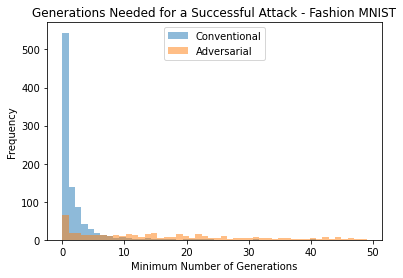

In [56]:
bins = np.linspace(0, 49, 49)
full_bins = np.linspace(0, 50, 50)
plt.hist(min_gens_fashion_mnist, bins, alpha=0.5, label='Conventional')
plt.hist(min_gens_fashion_mnist_adv, bins, alpha=0.5, label='Adversarial')
plt.xlabel('Minimum Number of Generations')
plt.ylabel('Frequency')
plt.legend(loc="upper center")
plt.title('Generations Needed for a Successful Attack - Fashion MNIST')
plt.savefig('fashion-mnist-generations-dist.png')
plt.show()

In [60]:
min_gens_mnist = analyze_robustness('MNIST.pt', test_loader=mnist_test_loader)

Correct: 98/100 , Successful Attacks: 90/98
Correct: 197/200 , Successful Attacks: 178/197
Correct: 296/300 , Successful Attacks: 263/296
Correct: 393/400 , Successful Attacks: 350/393
Correct: 492/500 , Successful Attacks: 438/492
Correct: 591/600 , Successful Attacks: 522/591
Correct: 689/700 , Successful Attacks: 610/689
Correct: 787/800 , Successful Attacks: 698/787
Correct: 885/900 , Successful Attacks: 781/885
Correct: 984/1000 , Successful Attacks: 863/984


In [62]:
min_gens_mnist_adv = analyze_robustness('MNIST_adv.pt', test_loader=mnist_test_loader)

Correct: 99/100 , Successful Attacks: 11/99
Correct: 199/200 , Successful Attacks: 23/199
Correct: 297/300 , Successful Attacks: 32/297
Correct: 396/400 , Successful Attacks: 37/396
Correct: 494/500 , Successful Attacks: 46/494
Correct: 593/600 , Successful Attacks: 53/593
Correct: 693/700 , Successful Attacks: 63/693
Correct: 791/800 , Successful Attacks: 74/791
Correct: 891/900 , Successful Attacks: 79/891
Correct: 991/1000 , Successful Attacks: 89/991


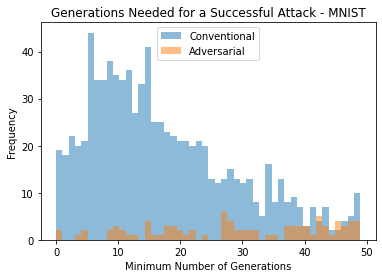

In [65]:
plt.hist(min_gens_mnist, bins, alpha=0.5, label='Conventional')
plt.hist(min_gens_mnist_adv, bins, alpha=0.5, label='Adversarial')
plt.xlabel('Minimum Number of Generations')
plt.ylabel('Frequency')
plt.legend(loc="upper center")
plt.title('Generations Needed for a Successful Attack - MNIST')
plt.savefig('mnist-generations-dist.png')
plt.show()